In [4]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter
import time

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

time1 = time.time()

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f:  
    DCBS_DataFrame = pickle.load(f)
    

with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)

    
# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()

# 提取B区信息
B_DF = DTBS_DataFrame['B']

# 提取C区信息
C_DF = DTBS_DataFrame['C']

# 提取D区信息
D_DF = DTBS_DataFrame['D']

In [5]:
# 回测模块，直接全部照抄backtest
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

def get_current_total_money(current_date, current_money, current_position_details, A_DF):
    
    """
    这个函数用于获取当前时刻账户内现金+转债价值之和,返回账户总市值
    current_date：现在的日期，
    current_money：代表账户内的现金数目,
    current_position_details：传入持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    """
    
    if current_position_details == {}:
        current_total_money = current_money
    else:
        # 获取当日转债价格字典
        current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
        current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()        
        current_total_money = current_money   
        
        for hold_bond_code,hold_num in current_position_details.items():            
            # price = float(A_DF.loc[(A_DF['bond_code'] == hold_bond_code) & (A_DF['date'] == current_date),'dp'])
            price = current_day_price_Dict[hold_bond_code]
            bond_money = price * hold_num
            current_total_money = current_total_money + bond_money    
            
    return current_total_money

def display(profit, trade_dates_list, C_DF, photo_title, tick_spacing = 10):
    
    # x轴
    x = trade_dates_list[1:]
    
    # 图片名
    photo_title = trade_dates_list[0] + ' 至 ' + trade_dates_list[-1] + '  ' + photo_title
    
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    print('单周收益率：', weekly_return, '\n', '累积收益率：',cumulative_return, 
          '\n用累加算法算出的策略累计收益率：',sum(weekly_return), '\n用累加算法算出的中证转债累计收益率：', sum(zi_weekly_return))
    
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, cumulative_return, color='red', label="策略累计净收益率",linewidth=1)
    plt.plot(x, zi_cumulative_return, color='green', label="中证转债累计净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, weekly_return, color='red', label="策略单周净收益率",linewidth=1)
    plt.plot(x, zi_weekly_return, color='green', label="中证转债单周净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    return weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return


def calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return):
    # 用于获取各类指标
    
    # 周期
    print('周期：', trade_dates_list[0], '至', trade_dates_list[-1])
        
    # 获取策略累计收益率 my_cumulative_return
    my_cumulative_return = cumulative_return[-1]
    print('策略累计收益率：', my_cumulative_return)
    
    # 获取中证转债累计收益率 zzzz_cumulative_return
    zzzz_cumulative_return = zi_cumulative_return[-1]
    print('中证转债累计收益率：', zzzz_cumulative_return)
    
    # 统计胜率1（收益率大于0的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_one = len([i for i in weekly_return if i > 0]) / len([i for i in weekly_return if i != 0])
    print('胜率1（收益率大于0的比例）：', win_rate_one)
    
    # 统计胜率2（收益率高于中证转债指数的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_two = len([i for i in range(len(weekly_return)) if (weekly_return[i] > zi_weekly_return[i]) & (weekly_return[i] != 0)]) / len([i for i in weekly_return if i != 0])
    print('胜率2（收益率高于中证转债指数的比例）：', win_rate_two)
    
    # 年化夏普比率，下面这三个的算法不确定，需要确认
    # rf为无风险收益率（10年期国债，暂时取2.684%，这个需要随着时间改动）
    rf = 0.027 / 52    
    avg_rate = np.mean(weekly_return)
    std_rate = np.std(weekly_return)
    sharp_ratio = ((avg_rate - rf) / std_rate) * sqrt(52)
    print('夏普比率：',sharp_ratio)
    
    
    # 最大回撤 max_drawdown
    max_drawdown = 0
    cumulative_return_list = cumulative_return
    cumulative_return_list.insert(0,0)
    for i in range(1,len(cumulative_return_list)):
        temp = (max(cumulative_return_list[0:i]) - cumulative_return_list[i])/(1 + max(cumulative_return_list[0:i]))
        if max_drawdown < temp:
            max_drawdown = temp                
    print('最大回撤：',max_drawdown)   
    
    # 年化波动率
    log_return_list = [log(i+1) for i in weekly_return]
    Volatility = std(log_return_list) / sqrt(5)
    annualVolatility = Volatility * sqrt(252) 
    print('年化波动率：',annualVolatility)
    
    
    
    # 收益最好的一周
    print('收益率最好的一周：',trade_dates_list[weekly_return.index(max(weekly_return))],'至',trade_dates_list[weekly_return.index(max(weekly_return)) + 1])
    
    # 最高单周收益率
    print('最高单周收益率',max(weekly_return))
    
    # 收益最差的一周
    print('收益率最差的一周：',trade_dates_list[weekly_return.index(min(weekly_return))],'至',trade_dates_list[weekly_return.index(min(weekly_return)) + 1])
    
    # 最低单周收益率
    print('最低单周收益率',min(weekly_return))

In [6]:
# DataFrame新增列用于存放前一天收盘价、涨跌幅
A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
A_DF['lastday_dp'] = A_DF.groupby('bond_code')['dp'].shift(1)
A_DF['change'] = A_DF['dp'] / A_DF['lastday_dp'] - 1
A_DF = pd.merge(A_DF, B_DF[['bond_code', 'sn', 'cn', 'sc']].drop_duplicates(), on='bond_code', how='left')

# 设定选择区间为n天，得到网格的最高点与最低点
A_DF.sort_values(['bond_code', 'date'], ascending=[True,True], inplace=True)
grouped = A_DF.groupby('bond_code')
n = 126

# 两种不同的计算方式，一种是计算前20天收盘价的最高价、最低价（不含当天），一种是计算前20天收盘价的最高价、最低价（含当天）
# A_DF['highest_price_n_days'] = grouped['dp'].rolling(window=n+1, min_periods=n+1).apply(lambda x: x[:-1].max(), raw=True).reset_index(level=0, drop=True)
# A_DF['lowest_price_n_days'] = grouped['dp'].rolling(window=n+1, min_periods=n+1).apply(lambda x: x[:-1].min(), raw=True).reset_index(level=0, drop=True)

A_DF['highest_price_n_days'] = grouped['dp'].rolling(window=n, min_periods=n).max().reset_index(level=0, drop=True)
A_DF['lowest_price_n_days'] = grouped['dp'].rolling(window=n, min_periods=n).min().reset_index(level=0, drop=True)

# 平均换手率 衡量转债活跃程度
A_DF['avg_trt'] = grouped['trt'].rolling(window=n, min_periods=n).mean().reset_index(level=0, drop=True)

print(A_DF[(A_DF['date']=='2022-01-04') & (A_DF['lowest_price_n_days']>=0)])

        bond_code        date       cpr       dp         bl        trt  \
5812    110038.SH  2022-01-04   13.2906  150.570   6.303800  86.607443   
9056    110043.SH  2022-01-04   20.1582  122.300  29.213500   1.209200   
10297   110044.SH  2022-01-04  124.8837  206.880   0.708500  21.558200   
11533   110045.SH  2022-01-04   29.0305  118.950  29.496400   0.358800   
12985   110047.SH  2022-01-04   20.6081  122.070  22.461600   1.418900   
...           ...         ...       ...      ...        ...        ...   
391462  128141.SZ  2022-01-04   17.2994  130.300  12.702600   0.620400   
392097  128142.SZ  2022-01-04   41.0310  123.698   7.179800   1.282700   
392724  128143.SZ  2022-01-04   14.9148  129.990   2.443800   4.423800   
393318  128144.SZ  2022-01-04   20.7032  142.010   9.794600   0.678600   
393896  128145.SZ  2022-01-04   14.7608  143.661   3.796918   5.130134   

            ytm        yl        dl  ia  ...  xx30  hs  lastday_dp    change  \
5812   -33.5885  0.860274  163.


 128117.SZ 道恩转债
8810 155.0 113.43
单周收益率： [-0.008117999999999959, -0.0005429678127035764, 0.019635576546509492, 0.009297898641666302, 0.012985123888137995, -0.011907553281276906, -0.008659108174845831, -0.0036510670480531804, -0.006019289105371306, 0.0014219886039821272, 0.007994778464848862, -0.005368739366020114, 0.00451470964473577, -0.0022976888525774175, -0.012736179401537595, 0.0018449456818205867, -0.006881992348531041, 0.005754753524907619, -0.005245007008594538, 0.003850641152167933, 0.001973642959692601, 0.006910028904507426, -0.0075015405610971975, -0.0015656919900199906, 0.004362155734073392, -0.0010858024939432998, 0.003990892842960392, 0.004575629720830809, -0.0035085246246319146, -0.002273571257185525] 
 累积收益率： [-0.008117999999999959, -0.008656560000000035, 0.010809040000000047, 0.020207440000000076, 0.033454960000000256, 0.021149040000000285, 0.012306800000000395, 0.008610800000000252, 0.002539680000000377, 0.003965280000000293, 0.011991760000000351, 0.00655864000000039

<Figure size 36000x18000 with 0 Axes>

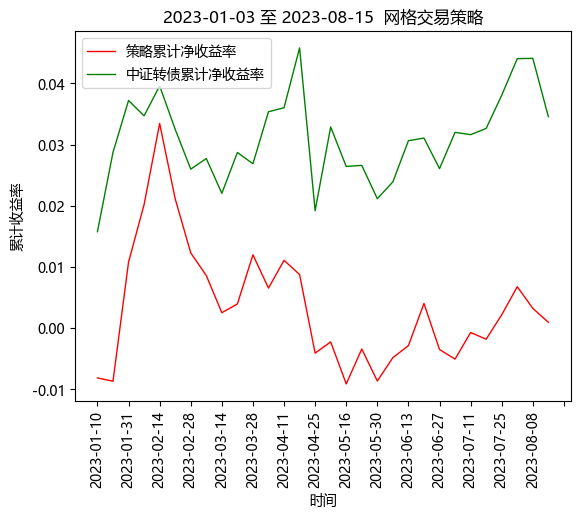

<Figure size 36000x18000 with 0 Axes>

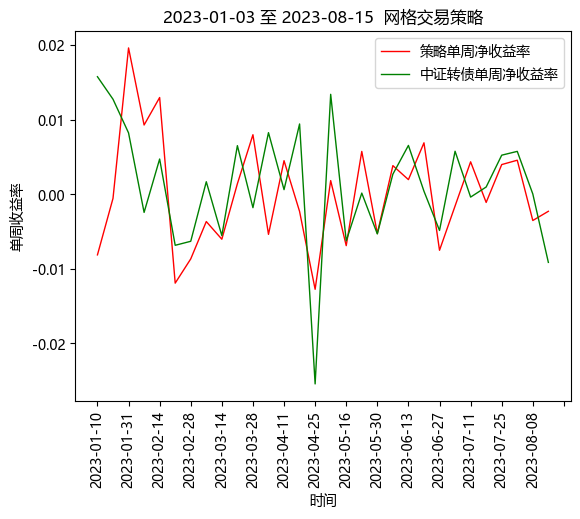

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.0009688800000002828
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.4666666666666667
胜率2（收益率高于中证转债指数的比例）： 0.4
夏普比率： -0.4598918790964861
最大回撤： 0.04117489551745893
年化波动率： 0.051217479440896066
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率 0.019635576546509492
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.012736179401537595

 123088.SZ 威唐转债
8680 146.99 115.096
单周收益率： [0.013713439999999855, 0.0017662979786476907, 0.01887175309488698, 0.022779339040347457, 0.015030418128500145, -0.007033969616953573, -0.014406617620406958, -0.011634463025258834, -0.008056400472265746, 0.00536477641528621, -0.003684824266050657, 0.0021327736114762352, -0.006618403239365356, 0.0019221619478999585, -0.033602514238799674, -0.004929015981314455, -0.009313897095799883, 0.010594893162223284, 0.03043922736788285, -0.009601665873081866, 0.022162718172660245, -0.002147531009475623, -0.003396366176011023, 0.03660111100795138, -0.0021611347000294323, 0.02537009576332383, -0.00438900830

<Figure size 36000x18000 with 0 Axes>

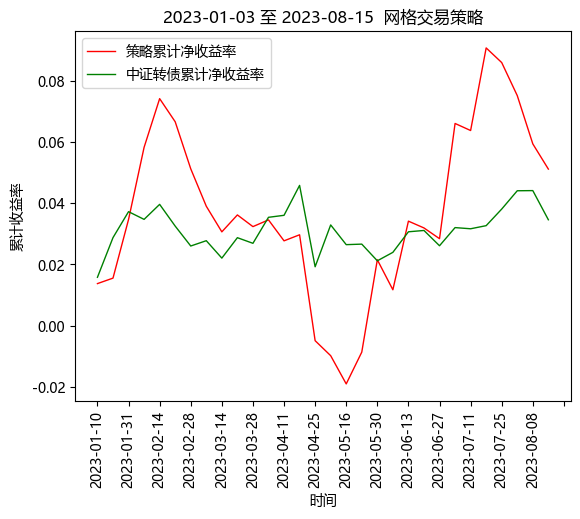

<Figure size 36000x18000 with 0 Axes>

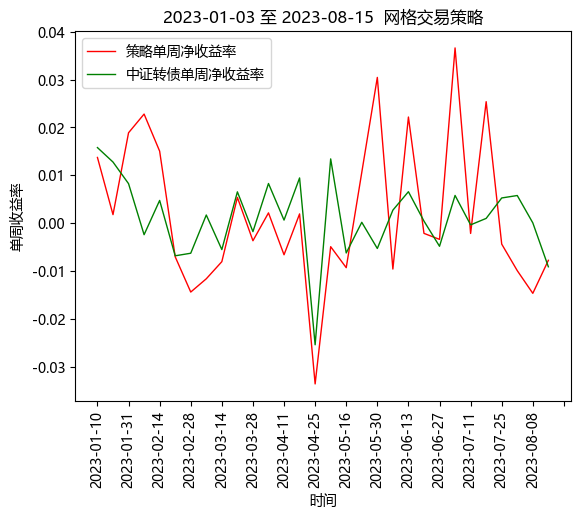

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.051127040000000346
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.43333333333333335
胜率2（收益率高于中证转债指数的比例）： 0.3333333333333333
夏普比率： 0.5946346654242793
最大回撤： 0.08677364229427446
年化波动率： 0.10802305455595712
收益率最好的一周： 2023-06-27 至 2023-07-04
最高单周收益率 0.03660111100795138
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.033602514238799674

 123038.SZ 联得转债
8010 155.0 124.7
单周收益率： [0.016375200000000145, -0.004691180973325548, 0.025503970315750912, 0.008005342550157613, 0.009598053766237902, -0.0114315071918627, -0.011948489958607866, 0.015965716378125272, 0.005452079731702808, 0.01122400002430246, -0.00876072371914316, 0.009837511346020733, 0.0017931769242889306, -0.001439463159629173, -0.012390328343701129, 0.03557471342929497, 0.03808973454520381, -0.013356532599773208, 0.013977682391141721, 0.008049841227473653, 0.0008917207267977734, 0.007144906743185242, -0.0031805506237062575, 0.01111341933882759, -0.0002826759623391073, 0.016220533043129315, 0.000761434

<Figure size 36000x18000 with 0 Axes>

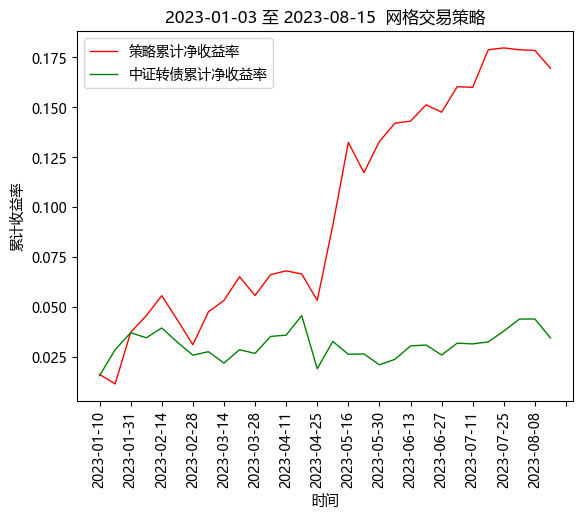

<Figure size 36000x18000 with 0 Axes>

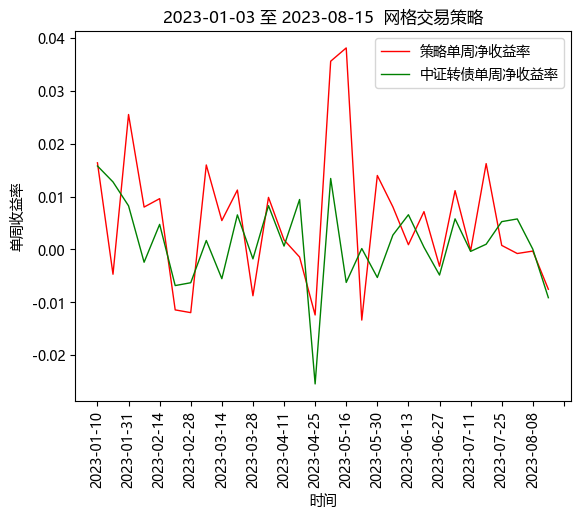

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.16956559999999943
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.6
胜率2（收益率高于中证转债指数的比例）： 0.6666666666666666
夏普比率： 2.699046339514412
最大回撤： 0.02324340790157678
年化波动率： 0.0900918269083708
收益率最好的一周： 2023-05-09 至 2023-05-16
最高单周收益率 0.03808973454520381
收益率最差的一周： 2023-05-16 至 2023-05-23
最低单周收益率 -0.013356532599773208

 127028.SZ 英特转债
8640 154.05 115.692
单周收益率： [0.008697600000000083, 0.010437141914484416, 0.02402435920168089, -0.009116578316603507, 0.006045523178434653, 0.019300332027826217, -0.004171565357489526, 0.0002302325975118702, -0.008357843619168137, 0.010251697000639437, 0.0017145139759680017, 0.0028485572259711045, 0.002632346890160342, 0.00356031513898758, -0.027803229938834884, 0.033750182954251695, 0.003212379755982653, -0.004702374946450982, -0.012719450602504567, -0.0031510153370718497, 0.0025595178826853804, 0.0005045427113608003, 0.0038355276592416665, 0.005645009292577496, 0.0038889418144789634, 0.003277508729086387, 0.01007572946780555,

<Figure size 36000x18000 with 0 Axes>

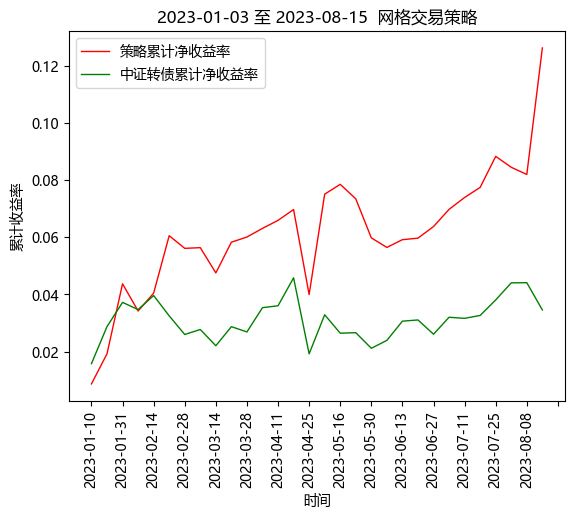

<Figure size 36000x18000 with 0 Axes>

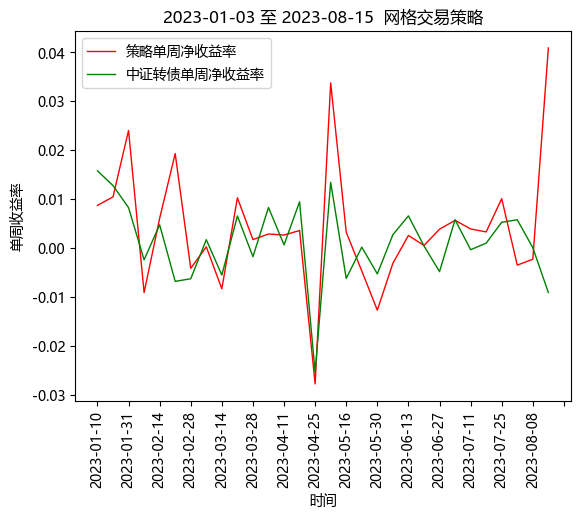

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.12619734999999976
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.7
胜率2（收益率高于中证转债指数的比例）： 0.5
夏普比率： 1.9785588853232425
最大回撤： 0.027803229938834904
年化波动率： 0.09064650392333921
收益率最好的一周： 2023-08-08 至 2023-08-15
最高单周收益率 0.0408992766111953
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.027803229938834884

 113600.SH 新星转债
8730 147.26 114.477
单周收益率： [0.014353870000000102, 0.0017329751006915917, 0.020965174971114386, -0.002162221186227997, 0.007584414316792021, 0.019699752851982444, -0.016188421708238865, -0.0012788137840737956, -0.0075074754232337115, 0.00415905222928048, -0.004114547738544583, 0.00036340237644250095, 0.0010225387999194258, -0.0025537357059545185, -0.021097906560000323, -0.00359459345581592, -0.004412554487447484, 0.0050797615049313904, 0.004929870728350716, 0.002714707760842483, 0.004794748169353769, 0.019773209640985945, -0.011772470336976149, 0.02691819385658989, 0.017139509208451642, -0.002305260620976024, 0.004480106828415709, -0.00187

<Figure size 36000x18000 with 0 Axes>

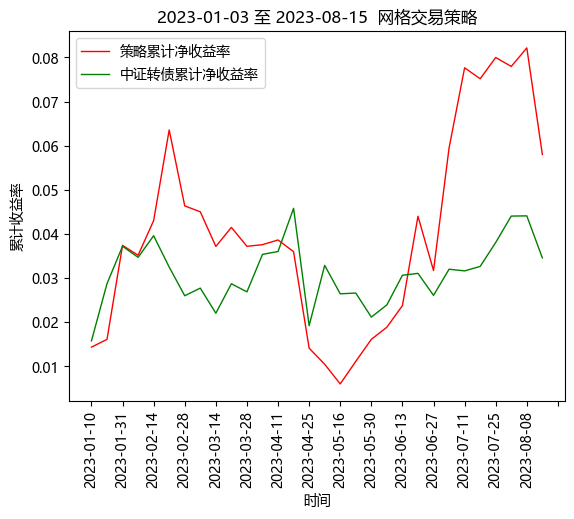

<Figure size 36000x18000 with 0 Axes>

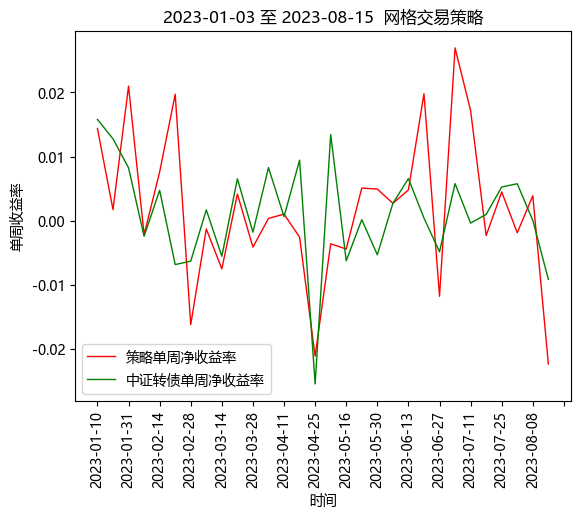

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.05800780000000039
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.5666666666666667
胜率2（收益率高于中证转债指数的比例）： 0.4666666666666667
夏普比率： 0.892740784019361
最大回撤： 0.05410868952473882
年化波动率： 0.08174815162377669
收益率最好的一周： 2023-06-27 至 2023-07-04
最高单周收益率 0.02691819385658989
收益率最差的一周： 2023-08-08 至 2023-08-15
最低单周收益率 -0.022306684773512053

 123145.SZ 药石转债
8450 149.77 118.3
单周收益率： [0.019144569999999916, 0.026516915063384827, 0.011386858534175426, 0.0030398975232270864, 0.0024828460555732512, -0.013734019885195514, -0.004334030666722222, -0.0013861475314239646, 0.0009360936131568298, -0.0026717564086525813, 0.02101027826217261, -0.012706201535137462, 0.005327863285871537, -0.00016713785215660693, -0.0663152126158214, -0.004001553936101798, 0.012002503590831326, -0.0003749672621056188, -0.005468829645274065, -0.006233037831041455, -0.0025716537248945404, 0.006553202816888648, -0.015508875013010237, 0.0012895309789400233, -0.0015489250068098093, -0.0079570919680418

<Figure size 36000x18000 with 0 Axes>

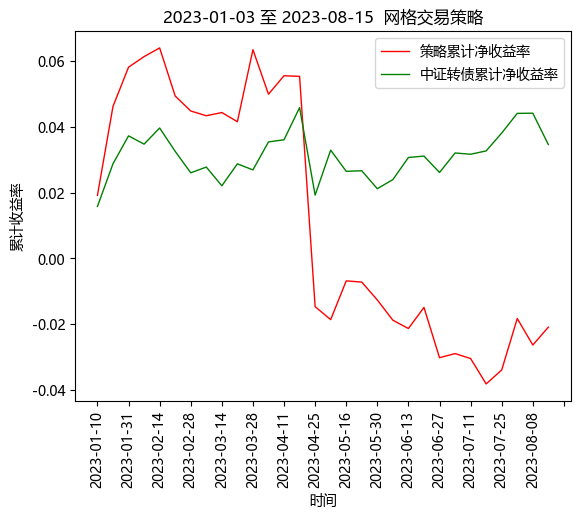

<Figure size 36000x18000 with 0 Axes>

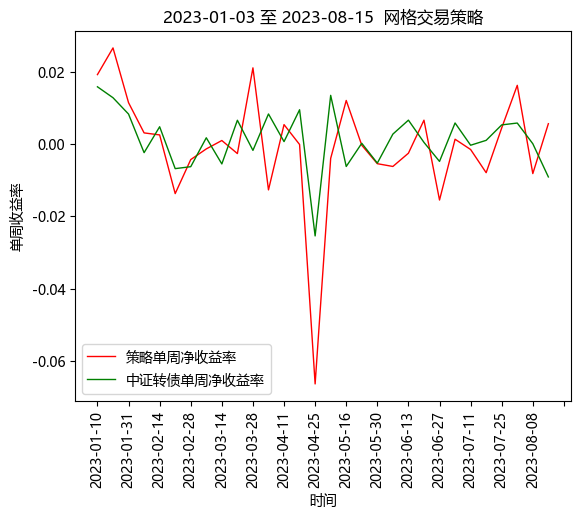

周期： 2023-01-03 至 2023-08-15
策略累计收益率： -0.020903479999999752
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.4666666666666667
胜率2（收益率高于中证转债指数的比例）： 0.4
夏普比率： -0.5028917249882481
最大回撤： 0.09595677442988322
年化波动率： 0.11366786462379776
收益率最好的一周： 2023-01-10 至 2023-01-17
最高单周收益率 0.026516915063384827
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.0663152126158214

 128042.SZ 凯中转债
8710 149.391 114.8
单周收益率： [0.03881939999999995, 0.007949447228266848, 0.009691432182895365, 0.003293281567127604, 0.00600310061160525, -0.011190175785213974, -0.010654707208463288, -0.0002466923047079739, -0.0154054010391651, 0.013998823110805914, 0.01590386656840903, -0.004916657286359483, -0.005301898967757346, -0.005946295078876673, -0.03969198407697272, -2.6965847529258902e-05, 0.00883894727691703, 0.016511569272294135, -0.0011400639016113656, -0.0022555549013338894, 0.02582218333587183, 0.020156497871260726, -0.006579844775195243, 0.02259988235497734, -0.0036028064785766922, 0.0037411825264779264, -0.0096423077095427

<Figure size 36000x18000 with 0 Axes>

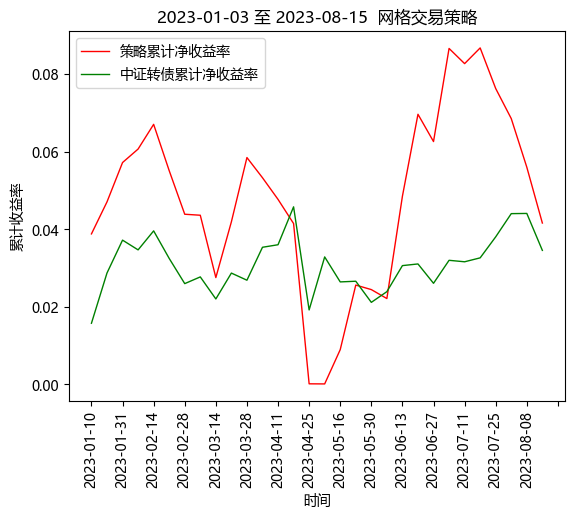

<Figure size 36000x18000 with 0 Axes>

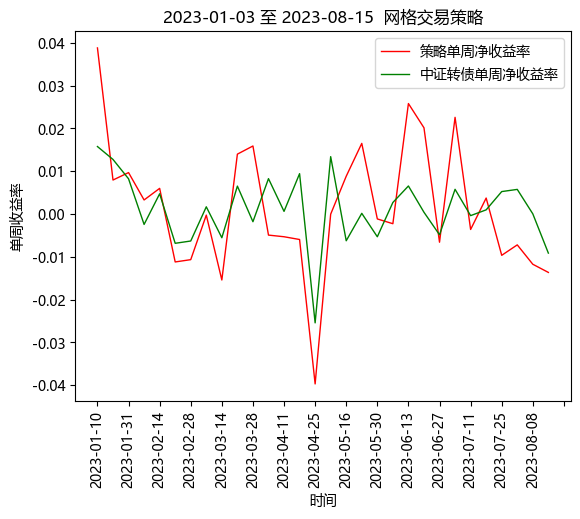

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.041622539999998764
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.43333333333333335
胜率2（收益率高于中证转债指数的比例）： 0.43333333333333335
夏普比率： 0.45925630589900623
最大回撤： 0.06273917791242346
年化波动率： 0.10605217035897518
收益率最好的一周： 2023-01-03 至 2023-01-10
最高单周收益率 0.03881939999999995
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.03969198407697272

 113636.SH 甬金转债
8740 147.5 114.375
单周收益率： [0.0002830199999999117, 0.007326326503073188, 0.04107037611780906, 0.002165998216959064, 0.015261220342106974, -0.00566427679272552, 0.00858219532228044, -0.021606747639282275, -0.0027246434049406076, 0.011502645371838316, -0.019976719160412992, 0.0009288403653624488, -0.0028793936274807974, 0.013977824838508734, -0.019049003729050273, -0.013783391844146786, 0.001209709928891467, 0.01102133401349037, -0.021976030157389137, 0.008749333046247143, 0.008501431847397933, -0.010541895735084572, -0.0008793120587493597, -0.005220388556282818, 0.0018868475007249863, 0.006009348943253556, 0

<Figure size 36000x18000 with 0 Axes>

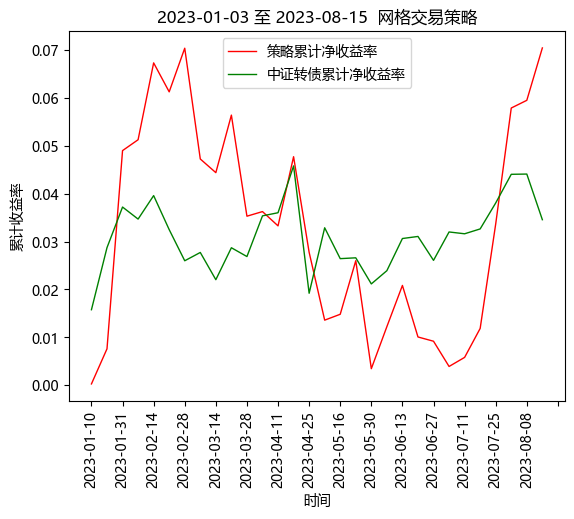

<Figure size 36000x18000 with 0 Axes>

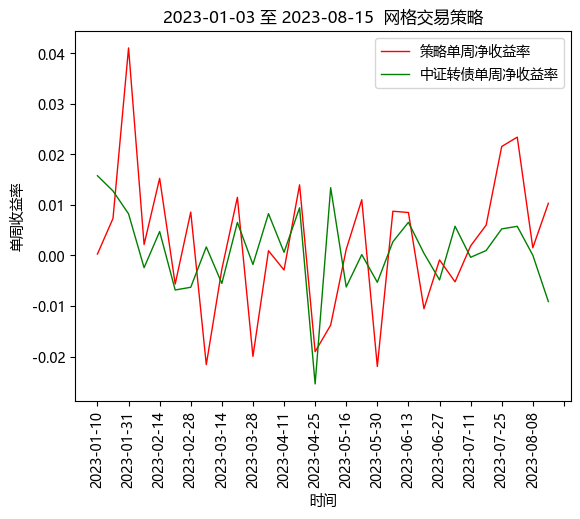

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.07043378999999916
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.6333333333333333
胜率2（收益率高于中证转债指数的比例）： 0.6666666666666666
夏普比率： 0.9634808200094422
最大回撤： 0.06251182240217545
年化波动率： 0.09774282637879296
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率 0.04107037611780906
收益率最差的一周： 2023-05-23 至 2023-05-30
最低单周收益率 -0.021976030157389137

 111004.SH 明新转债
8200 159.297 121.909
单周收益率： [0.003306239999999905, 0.0014784917514316653, 0.020783395433563445, 0.007341582775695743, -0.023973748730911848, -0.012439459530514507, -0.007628665104001842, -0.01178444143215196, 0.0004852941616153572, 0.023772914718080518, -0.017318938551444396, -0.0032115229239056964, -0.0005790997566482714, 0.0037512574820410816, -0.0930230272711361, 0.008756155101226515, 0.015190263127176307, 0.020037448831077276, 0.0008012501650123127, -0.0030440725527848267, 0.029923881272701625, 0.019376494082020468, 0.0010086591750078089, 0.01608197919725529, 0.0035262999974725595, -0.013861287699470926, 

<Figure size 36000x18000 with 0 Axes>

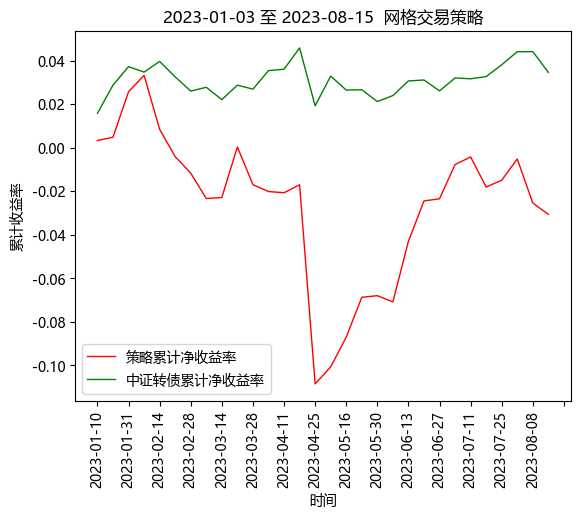

<Figure size 36000x18000 with 0 Axes>

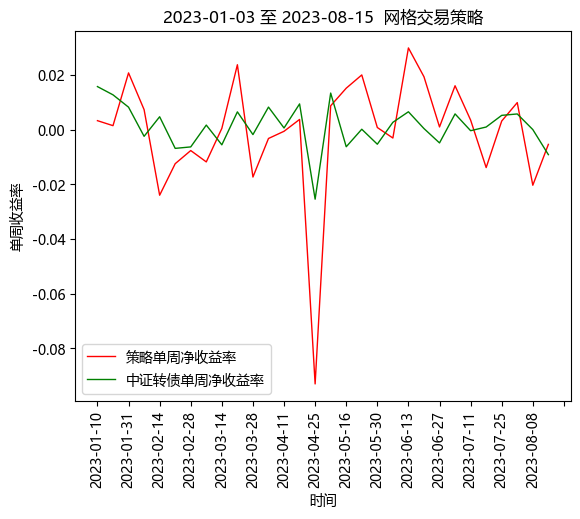

周期： 2023-01-03 至 2023-08-15
策略累计收益率： -0.030636020000000208
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.6
胜率2（收益率高于中证转债指数的比例）： 0.4666666666666667
夏普比率： -0.4394539034272532
最大回撤： 0.13711711261436768
年化波动率： 0.15759164159080305
收益率最好的一周： 2023-06-06 至 2023-06-13
最高单周收益率 0.029923881272701625
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.0930230272711361

 111000.SH 起帆转债
8260 152.657 120.921
单周收益率： [0.012544870000000152, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.006273104716831068, 0.017163525087685372, -0.0025343371267716464, -0.002131115557627572, -0.003171474049849188, -0.005860746796086391, -0.03602860857327439, 0.026593715058987, 0.04747414887771617, -0.008027792403722867, -0.017754735691350554, -9.036733714462564e-05, 0.009351128107277118, -0.008632868271970184, -0.014306902127277366, 0.022120709621377133, -0.013264283026426238, -0.005875333251402326, -0.012387662353982698, 0.026402750369935557, -0.014996351481460501, -0.015551951629262595] 
 累积收益率： [0.012544870000000152, 0.012544870000

<Figure size 36000x18000 with 0 Axes>

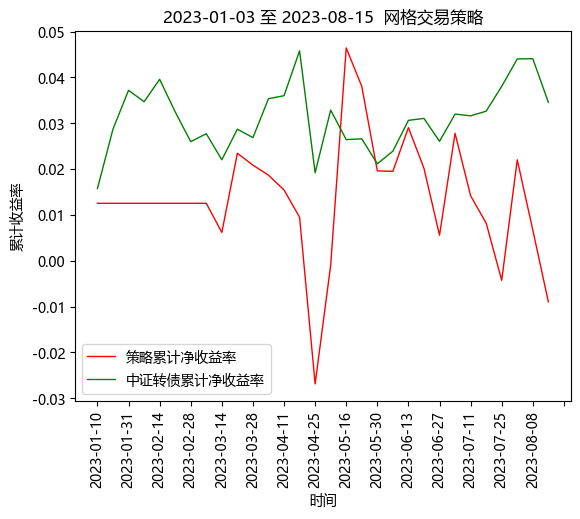

<Figure size 36000x18000 with 0 Axes>

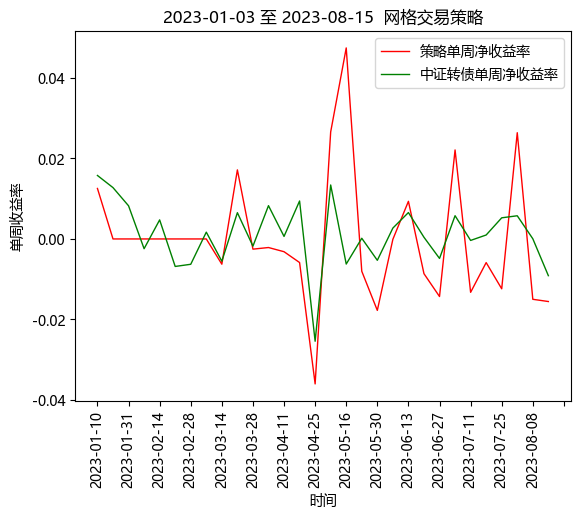

周期： 2023-01-03 至 2023-08-15
策略累计收益率： -0.008951700000000007
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.30434782608695654
胜率2（收益率高于中证转债指数的比例）： 0.2608695652173913
夏普比率： -0.31498626642122624
最大回撤： 0.05293988633481701
年化波动率： 0.11209786632829025
收益率最好的一周： 2023-05-09 至 2023-05-16
最高单周收益率 0.04747414887771617
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.03602860857327439

 123120.SZ 隆华转债
8350 154.5 119.72
单周收益率： [0.014361799999999869, 0.008398650264629381, 0.054757294511276644, 0.005667902012034931, 0.0076805543399967036, -0.01625764514172945, -0.009534963886503323, 0.00633514681939662, -0.00906611345284758, 0.02293371305907299, -0.017688206582259114, 0.0026150648486960026, 0.01011808449582996, 0.01409665897496959, -0.030842947041392454, 0.014008743952314662, -0.0010426475674500946, 0.007233911661982395, 0.0050743609669621215, -0.016544055645652422, 2.1800227512080994e-05, 0.014531793254247694, 0.001276528611899197, 0.003930561711658287, -0.004818321662838465, -0.004324411672104067, 0.011

<Figure size 36000x18000 with 0 Axes>

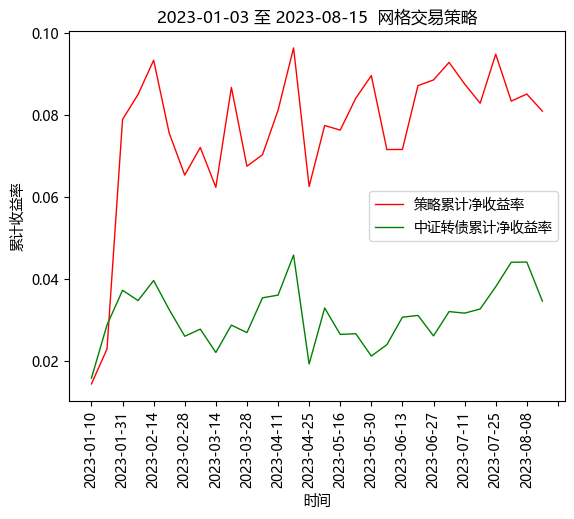

<Figure size 36000x18000 with 0 Axes>

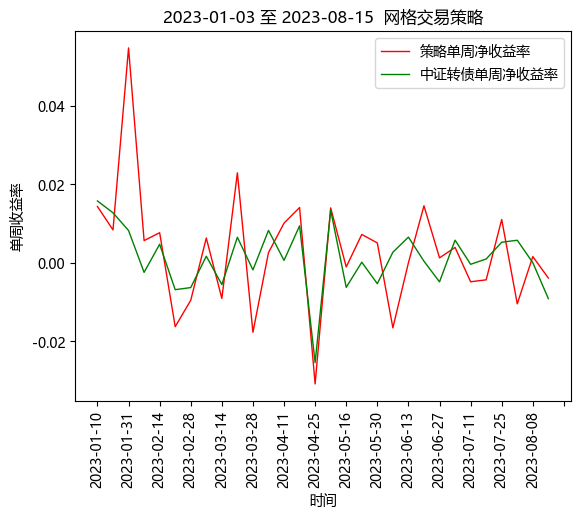

周期： 2023-01-03 至 2023-08-15
策略累计收益率： 0.08089762999999905
中证转债累计收益率： 0.03456927158963907
胜率1（收益率大于0的比例）： 0.6333333333333333
胜率2（收益率高于中证转债指数的比例）： 0.5333333333333333
夏普比率： 1.0493130650357767
最大回撤： 0.03084294704139245
年化波动率： 0.10587200855089991
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率 0.054757294511276644
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率 -0.030842947041392454


In [7]:
import bisect

start_day = '2023-01-03'
end_day = '2023-08-17'


# 先实验对某一只转债进行网格化交易

# 选债方法剔除掉目前价格过高的转债（存在下跌的风险），按回测开始日期前半年的正股年化波动率由高到低排序
# 113594.SH  113621.SH  127046.SZ  123088.SZ  113629.SH  127052.SZ  123121.SZ
trade_bond_code_list = ['128117.SZ', '123088.SZ', '123038.SZ', '127028.SZ', '113600.SH', '123145.SZ', '128042.SZ', '113636.SH', '111004.SH', '111000.SH', '123120.SZ']

for trade_bond_code in trade_bond_code_list:
    print('\n', trade_bond_code, B_DF.loc[B_DF['bond_code']==trade_bond_code, 'cn'].to_string(index=False))
    # 需要交易的转债只数
    trade_bond_code_count = 1

    day_list = sorted(list(A_DF[(A_DF['date'] >= start_day) & (A_DF['date'] <= end_day) & (A_DF['bond_code'] == trade_bond_code)]['date']))
    # print(day_list)


    # 设置初始资金100万元
    initial_money = 1000000

    # 每只转债的最大投入资金限额
    every_bond_max_money = int(initial_money/trade_bond_code_count)

    # 每只转债最大买入份额
    max_limit = int(every_bond_max_money / A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['lowest_price_n_days'] / 10) * 10

    # 设计 2k + 1 个格子
    n = 11

    # 设置网格的最高点/最低点
    max_price = float(A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['highest_price_n_days'])
    
    # 为了安全起见最低点设置为100元
    # min_price = 100.00
    min_price = float(A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['lowest_price_n_days'])

    print(max_limit, max_price, min_price)

    # 设置网格的价格比例
    q = (max_price/min_price) ** (1/(n-1))

    # 字典中存储每个价位应该持有的债券数量
    position_dict = {round(min_price * (q ** i),2) : int(max_limit * (1-i/(n-1)) / 10) * 10 for i in range(n)}

    # 网格价目表
    price_list = [round(min_price * (q ** i),2) for i in range(n)]

    # print(q,price_list,position_dict)


    total_money_list = []

    # dp列表
    A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
    dp_list = list(A_DF[(A_DF['date'].isin(day_list)) & (A_DF['bond_code'] == trade_bond_code)]['dp'])

    # print(len(day_list),len(dp_list))

    all_date_positon_details = {}
    for i in range(len(day_list)):  
        index_1 = bisect.bisect_left(price_list, dp_list[i])
        if index_1 > n-1:
            index_1 = n-1
        # print(index_1,dp_list[i])
        all_date_positon_details[day_list[i]] = {trade_bond_code : position_dict[price_list[index_1]]}

    # print(all_date_positon_details)


    # 统计每周账户净值
    test_day_list = list(D_DF[(D_DF['date'] >= start_day) & (D_DF['date'] <= end_day) & (D_DF['which_day'] == 'tue')]['date'])

    for i in range(len(day_list)):
        day = day_list[i]
        if i == 0:
            # 第一天换仓时
            total_money_list.append(initial_money)
            current_money = initial_money - get_current_total_money(day, 0, all_date_positon_details[day], A_DF)
        else:
            current_total_money = get_current_total_money(day, current_money, all_date_positon_details[day_list[i-1]], A_DF)
            current_money = current_total_money - get_current_total_money(day, 0, all_date_positon_details[day], A_DF)
            if day in test_day_list:
                total_money_list.append(current_total_money)

    profit = [total_money_list[i] / total_money_list[i-1] - 1 for i in range(1, len(total_money_list))]
    # print(profit)

    weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, test_day_list, C_DF, '网格交易策略', tick_spacing = 2)
    calculate_indicators(test_day_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- 分页，便于阅读 ---------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [115]:
from WindPy import w
import datetime

# 需要获取的日期
need_date = '2022-12-30'
A_DF_one_day = A_DF[A_DF['date']==need_date].copy()

stock_code_list = list(set(A_DF_one_day['sc']))
print(stock_code_list)
w.start()

# 获取年化波动率
volatilityratio = w.wsd(stock_code_list, "volatilityratio", need_date, need_date, "CalculationTime=126;AnnualCoefficient=252").Data[0]
print(volatilityratio)

mapping = dict(zip(stock_code_list, volatilityratio))
print(mapping)

A_DF_one_day['volatilityratio'] = A_DF_one_day['sc'].apply(lambda x : mapping[x])

['603638.SH', '600498.SH', '603876.SH', '300665.SZ', '300529.SZ', '300040.SZ', '600496.SH', '300297.SZ', '601665.SH', '300729.SZ', '002734.SZ', '603806.SH', '000688.SZ', '603887.SH', '002842.SZ', '688328.SH', '601998.SH', '300527.SZ', '300381.SZ', '300016.SZ', '688186.SH', '002787.SZ', '688030.SH', '605138.SH', '688208.SH', '002726.SZ', '300725.SZ', '605189.SH', '300486.SZ', '000070.SZ', '002714.SZ', '605358.SH', '603323.SH', '603618.SH', '300265.SZ', '300569.SZ', '002996.SZ', '600000.SH', '002861.SZ', '300894.SZ', '600745.SH', '300778.SZ', '603877.SH', '601229.SH', '000700.SZ', '300305.SZ', '002225.SZ', '600420.SH', '603466.SH', '300243.SZ', '002953.SZ', '603131.SH', '002806.SZ', '603898.SH', '603978.SH', '600105.SH', '300388.SZ', '002542.SZ', '300253.SZ', '300567.SZ', '002722.SZ', '300607.SZ', '300088.SZ', '603660.SH', '002698.SZ', '300545.SZ', '002823.SZ', '300869.SZ', '688066.SH', '603320.SH', '603516.SH', '300608.SZ', '002002.SZ', '002918.SZ', '002811.SZ', '002958.SZ', '300057.SZ'

In [116]:
A_DF_one_day

,bond_code,date,cpr,dp,bl,trt,ytm,yl,dl,ia,...,hs,lastday_dp,change,sn,cn,sc,highest_price_n_days,lowest_price_n_days,avg_trt,volatilityratio
9297,110043.SH,2022-12-30,14.3453,110.976,29.213300,2.238200,-3.0906,1.084900,125.3213,1,...,NaN,111.501,-0.004708,无锡银行,无锡转债,600908.SH,124.726,108.656,1.735113,27.251937
10536,110044.SH,2022-12-30,126.5483,194.752,0.707100,41.238000,-32.1140,1.490400,321.3003,1,...,NaN,194.899,-0.000754,广电网络,广电转债,600831.SH,245.610,181.478,63.312829,25.403955
11770,110045.SH,2022-12-30,34.8198,109.425,29.496100,0.586900,-0.0749,1.534200,144.2448,1,...,NaN,109.600,-0.001597,海澜之家,海澜转债,600398.SH,112.997,107.698,0.679241,26.600709
13220,110047.SH,2022-12-30,11.0204,114.721,22.461300,1.245200,0.1294,1.893200,125.7414,1,...,NaN,114.587,0.001169,山鹰国际,山鹰转债,600567.SH,120.002,111.094,1.020020,18.252374
14352,110048.SH,2022-12-30,9.1538,151.158,12.761700,2.361800,-14.9030,1.937000,160.3118,1,...,NaN,150.310,0.005642,福能股份,福能转债,600483.SH,215.880,141.430,4.902404,35.012969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390652,128141.SZ,2022-12-30,7.2753,123.500,12.701500,2.837100,-1.9653,3.964400,130.7753,1,...,NaN,123.860,-0.002907,旺能环境,旺能转债,002034.SZ,166.000,121.800,4.770708,32.876774
391285,128142.SZ,2022-12-30,54.3764,111.000,7.179800,0.892400,0.7538,3.967100,165.3764,1,...,NaN,110.851,0.001344,新乳业,新乳转债,002946.SZ,116.802,109.346,1.368771,31.617169
391910,128143.SZ,2022-12-30,48.7943,117.928,2.440700,2.036600,0.7000,4.024700,166.7223,1,...,NaN,117.898,0.000254,锋龙股份,锋龙转债,002931.SZ,158.402,117.151,56.705567,48.758392
392502,128144.SZ,2022-12-30,35.7857,113.478,9.794100,0.423700,0.0691,4.167100,149.2637,1,...,NaN,113.700,-0.001953,利民股份,利民转债,002734.SZ,127.979,113.478,2.203713,32.860781


In [117]:
# 后面为选择合适标的的过程
print(A_DF_one_day)

print('前n天最高价分位数：')
print(A_DF_one_day['highest_price_n_days'].min())
print(A_DF_one_day['highest_price_n_days'].quantile(0.25))
print(A_DF_one_day['highest_price_n_days'].quantile(0.5))
print(A_DF_one_day['highest_price_n_days'].quantile(0.75))
print(A_DF_one_day['highest_price_n_days'].max())
print('\n')

print('前n天平均换手率分位数：')
print(A_DF_one_day['avg_trt'].min())
print(A_DF_one_day['avg_trt'].quantile(0.25))
print(A_DF_one_day['avg_trt'].quantile(0.5))
print(A_DF_one_day['avg_trt'].quantile(0.75))
print(A_DF_one_day['avg_trt'].max())
print('\n')

print('年化波动率分位数：')
print(A_DF_one_day['volatilityratio'].min())
print(A_DF_one_day['volatilityratio'].quantile(0.25))
print(A_DF_one_day['volatilityratio'].quantile(0.5))
print(A_DF_one_day['volatilityratio'].quantile(0.75))
print(A_DF_one_day['volatilityratio'].max())

        bond_code        date       cpr       dp         bl          trt  \
9297    110043.SH  2022-12-30   14.3453  110.976  29.213300     2.238200   
10536   110044.SH  2022-12-30  126.5483  194.752   0.707100    41.238000   
11770   110045.SH  2022-12-30   34.8198  109.425  29.496100     0.586900   
13220   110047.SH  2022-12-30   11.0204  114.721  22.461300     1.245200   
14352   110048.SH  2022-12-30    9.1538  151.158  12.761700     2.361800   
...           ...         ...       ...      ...        ...          ...   
390652  128141.SZ  2022-12-30    7.2753  123.500  12.701500     2.837100   
391285  128142.SZ  2022-12-30   54.3764  111.000   7.179800     0.892400   
391910  128143.SZ  2022-12-30   48.7943  117.928   2.440700     2.036600   
392502  128144.SZ  2022-12-30   35.7857  113.478   9.794100     0.423700   
393078  128145.SZ  2022-12-30   -0.5971  136.000   3.400119  1143.055611   

            ytm        yl        dl  ia  ...  hs  lastday_dp    change    sn  \
9297   

In [127]:
# 条件1：设置网格上限不超过158元，即半年内最高价不超过158元
# 条件2：交易足够活跃，因此需要换手率较高，设置当日换手率>=2%
# 条件3：年化波动率>=50%

output_df = A_DF_one_day[(A_DF_one_day['highest_price_n_days']<=160) & 
                         (A_DF_one_day['highest_price_n_days'] - A_DF_one_day['lowest_price_n_days']>=30) & 
                         (A_DF_one_day['avg_trt']>=5) & 
                         (A_DF_one_day['volatilityratio']>=50) & 
                         (~A_DF_one_day['sn'].str.contains('ST'))].copy()
output_df.sort_values(by='volatilityratio',ascending=False, inplace=True)
print(output_df)
print(list(output_df['bond_code']))

        bond_code        date      cpr       dp         bl        trt     ytm  \
374606  128117.SZ  2022-12-30  82.3218  115.000   3.585500  28.890900  1.8534   
221227  123088.SZ  2022-12-30  56.8573  117.112   3.011300   1.377800  0.7159   
194082  123038.SZ  2022-12-30  91.2034  125.800   1.472600   5.405400 -2.4909   
239415  123125.SZ  2022-12-30  -0.6781  113.219   1.412758  67.563305 -0.7801   
275017  127028.SZ  2022-12-30  12.8866  120.600   5.760300  12.161900 -1.6852   
134639  113600.SH  2022-12-30  47.3436  114.477   4.530300   1.442300  2.5066   
246270  123145.SZ  2022-12-30  42.8575  123.816  11.494300   3.543100 -1.3905   
328187  128042.SZ  2022-12-30  28.6252  116.758   4.154300   0.781400 -1.6234   
151017  113636.SH  2022-12-30  50.0176  115.811   9.995400   2.077600  0.7834   
353332  128078.SZ  2022-12-30  12.2527  143.400   6.948700  21.614000 -7.5670   
42297   111004.SH  2022-12-30   9.1146  132.086   6.729600   5.906000 -1.6885   
40811   111000.SH  2022-12-3